# Classic Reccomendation System 

In [23]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
from tqdm import tqdm
import time
import sys
import psutil
from tabulate import tabulate
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

USER_ID = 35859          # user_id for which we are going to recommend movies
TOP = 20                 # number of movies to recommend

## Load and preprocess of data

In [3]:
# Load the books dataset
df_books_name = pd.read_csv("BX-Books.csv", on_bad_lines='skip', sep=';',low_memory=False)
df_books_name = df_books_name.iloc[:, :-3]
df_books_name = df_books_name.set_index('ISBN')
df_books_name = df_books_name.rename_axis(None)
print("Size of df_book:",sys.getsizeof(df_books_name)/1024/1024, "MB")

# Load the ratings dataset
df = pd.read_csv("BX-Book-Ratings.csv", on_bad_lines='skip', sep=';')
df = df[df['Book-Rating'] != 0]

#Remove the books that are not in the books_name dataset
df = df[df['ISBN'].isin(df_books_name.index)]


#Cut the dataframe
print("Number of ratings: ", df.shape[0])
cut = 200000
df = df[:cut]

# Remove the books with less than 2 ratings
df_filter = df.groupby('ISBN').filter(lambda x: len(x) >= 2)
print("Size of df book-ratings:",sys.getsizeof(df_filter)/1024/1024, "MB")

# Unique list of all the users and books
users = df_filter['User-ID'].unique()
books = df_filter['ISBN'].unique()
print("Number of books: ", len(books))
print("Number of ratings after cutting and filtering: ", df_filter.shape[0])

# Create an empty dataframe
start = time.time()
df_books = pd.DataFrame(0, index=users, columns=books)

print("Size of user-item matrix:",sys.getsizeof(df_books)/1024/1024, "MB")

#  fill the dataframe with the ratings 
for index, row in tqdm(df_filter.iterrows(), total=df_filter.shape[0]):
    df_books.at[row['User-ID'], row['ISBN']] = row['Book-Rating']
print("Time taken to create User-Books matrix: ", time.time() - start,"s")

Size of df_book: 84.88944053649902 MB
Number of ratings:  383842
Size of df book-ratings: 10.379700660705566 MB
Number of books:  27587
Number of ratings after cutting and filtering:  131131
Size of user-item matrix: 5916.7958984375 MB


100%|██████████| 131131/131131 [00:03<00:00, 37003.54it/s]

Time taken to create User-Books matrix:  4.689748287200928 s


In [3]:
df_books 

,038550120X,0060517794,0671537458,0679776818,0684867621,0451166892,0380711524,3453092007,0553572369,3499230933,...,0785281290,0380812894,0312855974,0425185729,0698119185,0590742590,0789403374,1883513073,0812545419,0812545427
276744,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
276747,0,9,9,8,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
276754,0,0,0,0,8,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
276755,0,0,0,0,0,5,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
276762,0,0,0,0,0,0,5,8,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137986,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
137987,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
137994,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
137999,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Top 10 books by Rating and top users by rating

In [4]:

print("Top most rated books in the dataset in this fomrat (ISBN, book title, authors, average rating, number of ratings)\n")
top = df_filter['ISBN'].value_counts().head(10)

table_data = []
for i in range(10):
    book = df_books.loc[:, top.index[i]].values.T
    mean = np.round(np.mean(book[book != 0]), 2)
    table_data.append([top.index[i], df_books_name.loc[top.index[i]]['Book-Title'], df_books_name.loc[top.index[i]]['Book-Author'], mean, top.values[i]])

table_headers = ["ISBN", "Book Title", "Authors", "Average Rating", "Number of Ratings"]
print(tabulate(table_data, headers=table_headers))

#top users with most ratings
top = df_filter['User-ID'].value_counts().head(30)
print("\nTop users with most ratings in this format (User-ID, number of ratings)\n")
table_user= []
for i in range(10):
    table_user.append([top.index[i], top.values[i]])

table_headers = ["User-ID", "Number of Ratings"]
print(tabulate(table_user, headers=table_headers))

Top most rated books in the dataset in this fomrat (ISBN, book title, authors, average rating, number of ratings)

ISBN        Book Title                                                        Authors            Average Rating    Number of Ratings
----------  ----------------------------------------------------------------  ---------------  ----------------  -------------------
0316666343  The Lovely Bones: A Novel                                         Alice Sebold                 8.16                  339
0971880107  Wild Animus                                                       Rich Shapero                 4.62                  286
0385504209  The Da Vinci Code                                                 Dan Brown                    8.44                  247
0312195516  The Red Tent (Bestselling Backlist)                               Anita Diamant                8.31                  185
0060928336  Divine Secrets of the Ya-Ya Sisterhood: A Novel                   Rebecca W

## Compute the item-item similarity matrix by calculating the cosine similarity between each pair of items.

In [10]:
start = time.time()
cpu = psutil.cpu_percent()
ram = psutil.virtual_memory()[3]/1024/1024
# Compute item-item similarity
item_similarity = cosine_similarity(df_books.T)
print("CPU usage before computing item-item similarity: ", cpu, "%")
print("CPU usage after computing item-item similarity: ", psutil.cpu_percent(), "%\n")

print("RAM usage before computing item-item similarity: ", ram, "MB")
print("RAM usage after computing item-item similarity", psutil.virtual_memory()[3]/1024/1024, "MB\n")

print(sys.getsizeof(item_similarity)/1024/1024, "MB")
print("Time taken to compute item-item similarity: ", time.time() - start)

# Example user's interactions
user_interactions = df_books.loc[USER_ID]

# Calculate item scores based on user's interactions and item similarity
item_scores = user_interactions.dot(item_similarity)

# Set the scores of the items that the user has already interacted with to 0
item_scores[user_interactions > 0] = 0

# Normalize the scores between 0 and 10
if item_scores.max() != item_scores.min():  # Check to avoid division by zero
    item_scores = (item_scores - item_scores.min()) / (item_scores.max() - item_scores.min()) * 10

# Sort items by score and recommend the top-n
recommended_items = np.argsort(item_scores)[::-1][:TOP]
print("Time taken to compute rhe recommendation: ", time.time() - start)

CPU usage before computing item-item similarity:  1.0 %
CPU usage after computing item-item similarity:  90.0 %

RAM usage before computing item-item similarity:  17506.46484375 MB
RAM usage after computing item-item similarity 17790.6015625 MB

5806.294136047363 MB
Time taken to compute item-item similarity:  53.477261781692505
Time taken to compute rhe recommendation:  53.590961933135986


## Top 20 recommendations for a user based on the items most similar to the items the user has liked.

In [16]:
print("Top " + str(TOP) + " recommended books for user " + str(USER_ID) + ":")

table_data = []
for item in recommended_items:
    Isnb = df_books.columns[item]
    title = df_books_name.loc[Isnb] 
    Pred = item_scores[item]
    table_data.append([title['Book-Title'] if len(title['Book-Title'])  < 40 else title['Book-Title'][:40]+"...",
                       title['Book-Author'],
                       Isnb,
                       Pred])


table_headers = ["Book Title", "Book Author", "ISBN","Predicted Rating"]
print(tabulate(table_data, headers=table_headers))


Top 20 recommended books for user 35859:
Book Title                                   Book Author            ISBN          Predicted Rating
-------------------------------------------  ---------------------  ----------  ------------------
The Invisible Dog                            Dick King-Smith        0679870415            10
Baby-Sitters Beware (Baby-Sitters Club S...  Ann M. Martin          0590228714             9.9322
USHER'S PASSING                              Robert McCammon        0671769928             9.87006
Caligula Le Malentendu (Folio No. 64)        Albert Camus           2070360644             9.83617
The Wedding Game : A Mystery at the Univ...  Susan Holtzer          0312978669             9.81309
A Rock and a Hard Place: One Boy's Trium...  Anthony Godby Johnson  051759501X             9.76387
Eleven Hours                                 Paullina Simons        0312967004             9.72654
Trojan Dog                                   Dorothy Johnston       1862544

## Comparison between predicted and actual ratings for a single User based on cosine similarity

In [22]:
#take all the books that the user has rated
user_books_ratings = df_books.loc[USER_ID]
user_books_ratings = user_books_ratings[user_books_ratings > 0]

#make a prediction for each book
predictions = []
for book_id in user_books_ratings.index:
    book_similarity = item_similarity[books == book_id]
    user_ratings = df_books.loc[USER_ID]
    predicted_rating = user_ratings.dot(book_similarity.T)
    predicted_rating = predicted_rating / 100
    if predicted_rating[0] > 10:
        predicted_rating[0] = 10
    book_ratings = user_books_ratings[book_id]
    predictions.append([book_id, np.round(predicted_rating[0]), book_ratings])

table_data = []
for prediction in predictions:
    book_title = df_books_name.loc[prediction[0]]['Book-Title']
    table_data.append([book_title if len(book_title) < 60 else book_title[:60] + "...",
                       prediction[1],
                       prediction[2]])
table_headers = ["Book Title", "Predicted Rating", "Actual Rating"]

print(tabulate(table_data, headers=table_headers))

Book Title                                                         Predicted Rating    Actual Rating
---------------------------------------------------------------  ------------------  ---------------
The Girl Who Loved Tom Gordon : A Novel                                           3                6
Charlotte's Web                                                                   4               10
She Said Yes: The Unlikely Martyrdom of Cassie Bernall                            5                8
Fahrenheit 451                                                                    2               10
A Cold Heart: An Alex Delaware Novel                                              5                7
Silent Partner (Alex Delaware Novels (Paperback))                                 5                8
The Cat in the Hat                                                                5               10
Hop on Pop (I Can Read It All by Myself Beginner Books)                           5        

## Evaluation of the system using Precision metric with threshold 

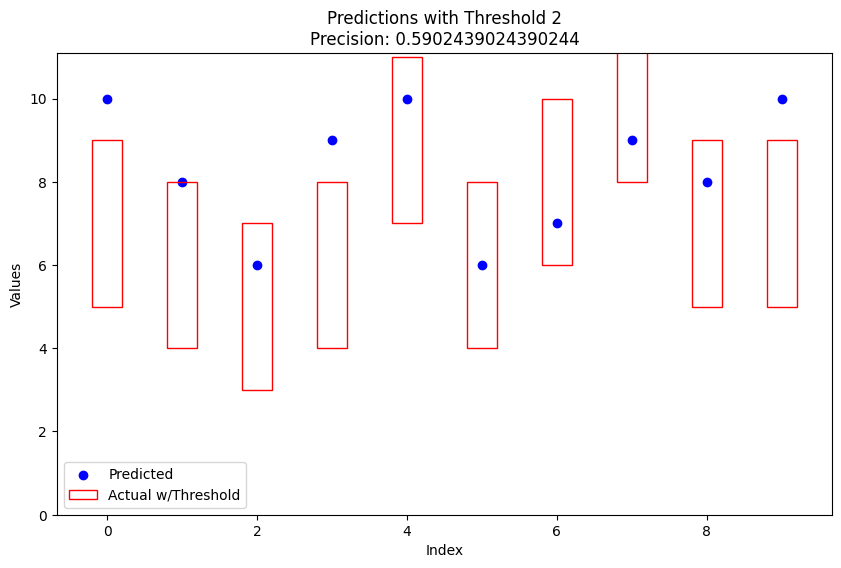

In [25]:
def precision_treshold(actual,predicted, threshold):
    v = []
    for i, pred in enumerate(predicted):
        if float(pred) <=  float(actual[i])+threshold and float(pred) >= float(actual[i])-threshold:
            v.append(1)
        else:
            v.append(0)

    m = sum(v)/len(v)
    return m

threshold = 2
actual = np.array(predictions)[:, 2]
predicted = np.array(predictions)[:, 1]
precision = precision_treshold(actual,predicted, threshold)

# Create scatter plot
plt.figure(figsize=(10, 6))
plt.ylim(0, 11.1)
plt.scatter(range(len( predicted[310:320])),  list(map(float, predicted[310:320])), color='blue', label='Predicted')
for i in range(len(actual[100:110])):
    plt.gca().add_patch(Rectangle((i-0.2,int(actual[i+310])-threshold),0.4,2*threshold,
                    edgecolor='red',
                    facecolor='none',
                    lw=1))
plt.gca().legend(('Predicted', 'Actual w/Threshold'))
plt.xlabel('Index')
plt.ylabel('Values')
plt.title(f'Predictions with Threshold {threshold}\nPrecision: {precision}')
plt.show()
x=0